### Cчитывание всех файлов с генами
И подсчет количества законченных экспериментов
(Берется количество генов в папке)

In [41]:
import glob
import os

In [42]:
path = os.getcwd()

print("Директория: " + path)

txtfiles_genes = []
for file in glob.glob("SimulationData/Genes/*.txt"):
    txtfiles_genes.append(file)
    
print("Количество завершенных экспериментов: " + str(len(txtfiles_genes)))

Директория: C:\Users\Public\Documents\Unity Projects\CellularAutomations\Statistics
Количество завершенных экспериментов: 1306


### Список всех паттернов, для которых проводились эксперименты

In [43]:
patterns = set()

statistics_count_start = 1
statistics_folders = 5
statistics_files = []

for sf_number in range(statistics_count_start, statistics_count_start + statistics_folders + 1):
    for file in glob.glob(f"SimulationData/Statistics{sf_number}/*.txt"):
        patterns.add(file.split('\\')[-1])
        statistics_files.append(file)
        
for file in glob.glob(f"SimulationData/Statistics/*.txt"):
    patterns.add(file.split('\\')[-1])
    statistics_files.append(file)
        
print(len(patterns), len(statistics_files))

14 33


In [44]:
# Получение файлов со статистикой по заданному паттерну (могут находиться в нескольких папках)
def get_pattern_files(pattern):
    pattern_files = []
    for sf_number in range(statistics_count_start, statistics_count_start + statistics_folders + 1):
        for file in glob.glob(f"SimulationData/Statistics{sf_number}/Stats-{pattern}.txt"):
            pattern_files.append(file)
    
    for file in glob.glob(f"SimulationData/Statistics/Stats-{pattern}.txt"):
        pattern_files.append(file)
        
    if (len(pattern_files) == 0):
        raise Exception('No matching pattern files found')
    return pattern_files


get_pattern_files("PtnElka552")

['SimulationData/Statistics1/Stats-PtnElka552.txt',
 'SimulationData/Statistics2/Stats-PtnElka552.txt',
 'SimulationData/Statistics3/Stats-PtnElka552.txt',
 'SimulationData/Statistics5/Stats-PtnElka552.txt',
 'SimulationData/Statistics/Stats-PtnElka552.txt']

### Интерфейс для вызова функций к определенным строкам файла со статистикой

In [45]:
def analyze(statistics_files, *funcs_indices):
    for file in statistics_files:
        f = open(file, 'r')
        cur_index = 0
        for line in f:
            for f_ind in funcs_indices:
                if (cur_index == f_ind[1]):
                    f_ind[0](line)
            cur_index += 1
            cur_index = cur_index % 10
        f.close()

###### Тестовая функция для проверки работоспособности интерфейса

In [46]:
heh_ans = 0
def test_heh(line):
    global heh_ans
    heh_ans += int(line.split(':')[-1])
    

analyze(statistics_files, (test_heh, 0))
heh_ans

35981

### Общее время работы успешных экспериментов

In [47]:
def calculate_success_time(statistics_files):
    success_time_accum = 0
    lastOK = False
    
    def is_success(line):
        nonlocal lastOK
        lastOK = True if line.split('|')[0] == "OK" else False
    

    def success_time(line):
        nonlocal success_time_accum
        if (lastOK):
            success_time_accum += int(line.split('.')[0].split(':')[1].split(',')[0])
    
    analyze(statistics_files, (is_success, 1), (success_time, 2))
    
    return success_time_accum


def interpret_success_time(success_time_accum, pattern_name):
    days = success_time_accum // 86400
    hours = (success_time_accum % 86400) // 3600
    minutes = (success_time_accum % 3600) // 60
    seconds = success_time_accum % 60
    print(f"На успешные эксперименты над {pattern_name} затрачено: " + 
          f"{days} дней {hours} часов, {minutes} минут, {seconds} секунд")
    

interpret_success_time(calculate_success_time(statistics_files), "всеми паттернами")

На успешные эксперименты над всеми паттернами затрачено: 13 дней 5 часов, 52 минут, 57 секунд


### Визуализация доли успешных экспериментов в графиках

In [48]:
pattern = "PtnCross551"

ptn_files = get_pattern_files(pattern)

interpret_success_time(calculate_success_time(ptn_files), pattern)

def success_ratio(pattern_files):   
    success_fail = (0, 0)
    def success_or_fail(line):
        nonlocal success_fail
    
    analyze(pattern_files, (success_or_fail, 1))
    return success_fail
        
    

На успешные эксперименты над PtnCross551 затрачено: 2 дней 3 часов, 57 минут, 10 секунд


### Визуализация времени работы по каждому паттерну в графиках

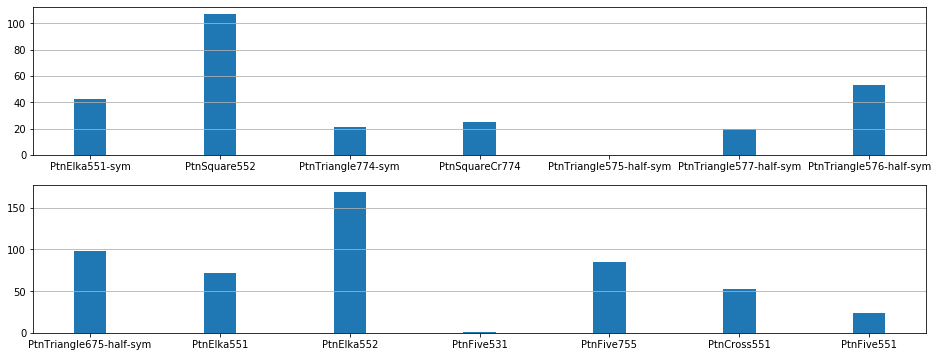

In [49]:
import matplotlib.pyplot as plt

def calculate_time(statistics_files, patterns):
    time_accum = dict()
    for pattern in patterns:
        time_accum[pattern.split('Stats-')[1].split('.txt')[0]] = 0

    current_pattern = ""
    
    def get_current_pattern(line):
        nonlocal current_pattern
        current_pattern = line.split('for')[1].split('after')[0].strip()
        
    def success_time(line):
        nonlocal time_accum
        time_acc = int(line.split('.')[0].split(':')[1].split(',')[0])
        if (time_acc > 0):
            time_accum[current_pattern] += int(line.split('.')[0].split(':')[1].split(',')[0])
    
    analyze(statistics_files, (get_current_pattern, 1), (success_time, 2))
    
    for entry in time_accum.keys():
        time_accum[entry] /= 3600
        
    return time_accum

res_time = calculate_time(statistics_files, patterns)
plt.rcParams["figure.figsize"] = (16,6)
fig, ax = plt.subplots(2, 1)
ax[0].bar(list(res_time.keys())[:7], list(res_time.values())[:7], 0.25)
ax[0].grid(True, axis='y')
ax[1].bar(list(res_time.keys())[7:], list(res_time.values())[7:], 0.25)
ax[1].grid(True, axis='y')


### Время работы всех экспериментов

In [50]:
all_time = 0
for val in res_time.values():
    all_time += val

print(f"На все эксперименты затрачено: {int(all_time) // 24} дней, {int(all_time) % 24} часов")

На все эксперименты затрачено: 32 дней, 0 часов


### Визуализация количества экспериментов по каждому паттерну

{'PtnElka551-sym': 22, 'PtnSquare552': 215, 'PtnTriangle774-sym': 3, 'PtnSquareCr774': 15, 'PtnTriangle575-half-sym': 1, 'PtnTriangle577-half-sym': 21, 'PtnTriangle576-half-sym': 84, 'PtnTriangle675-half-sym': 76, 'PtnElka551': 43, 'PtnElka552': 346, 'PtnFive531': 7, 'PtnFive755': 70, 'PtnCross551': 222, 'PtnFive551': 44}


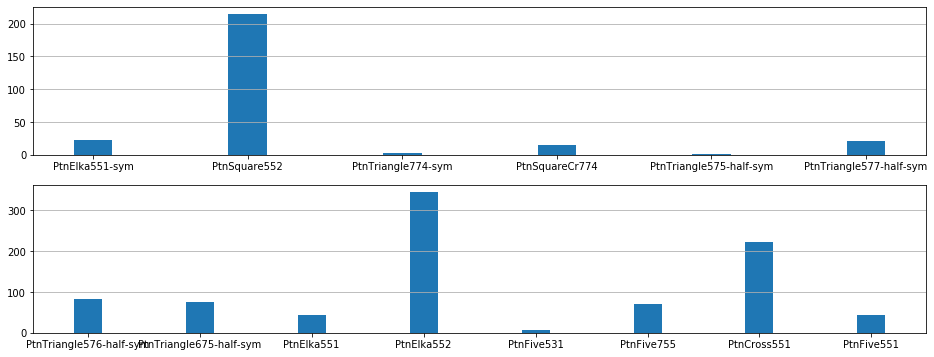

In [51]:
def calculate_exp(statistics_files, patterns):
    exp_accum = dict()
    for pattern in patterns:
        exp_accum[pattern.split('Stats-')[1].split('.txt')[0]] = 0

    current_pattern = ""
    
    def get_current_pattern(line):
        nonlocal current_pattern
        current_pattern = line.split('for')[1].split('after')[0].strip()
        
    def exp_add(line):
        nonlocal exp_accum
        exp_accum[current_pattern] += 1
    
    analyze(statistics_files, (get_current_pattern, 1), (exp_add, 2))
        
    return exp_accum


res_count = calculate_exp(statistics_files, patterns)
plt.rcParams["figure.figsize"] = (16,6)
fig, ax = plt.subplots(2, 1)
ax[0].bar(list(res_count.keys())[:6], list(res_count.values())[:6], 0.25)
ax[0].grid(True, axis='y')
ax[1].bar(list(res_count.keys())[6:], list(res_count.values())[6:], 0.25)
ax[1].grid(True, axis='y')
print(res_count)

### Среднее время экспериментов для некоторых паттернов (успешные и не успешные)

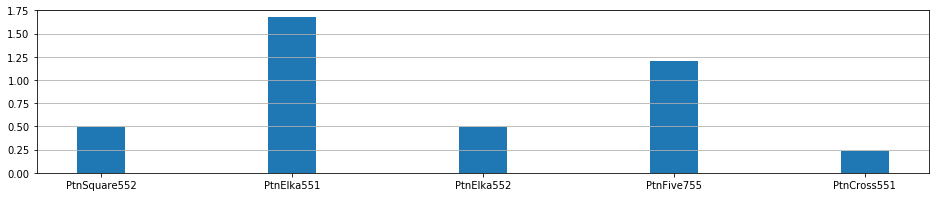

In [52]:
pattern_files = get_pattern_files("PtnSquare552") + get_pattern_files("PtnElka551")
pattern_files += get_pattern_files("PtnElka552") + get_pattern_files("PtnFive755") + get_pattern_files("PtnCross551")
#pattern_files += get_pattern_files("PtnElka552")

res_time = calculate_time(pattern_files, patterns)
res_count = calculate_exp(pattern_files, patterns)

res_average_time = dict()
for key in res_time.keys():
    if (res_count[key] != 0):
        res_average_time[key] = res_time[key] / res_count[key]


plt.rcParams["figure.figsize"] = (16,3)
fig, ax = plt.subplots(1, 1)
ax.bar(res_average_time.keys(), res_average_time.values(), 0.25)
ax.grid(True, axis='y')

### Средняя приспособленность по определенному паттерну с учетом процента мутации

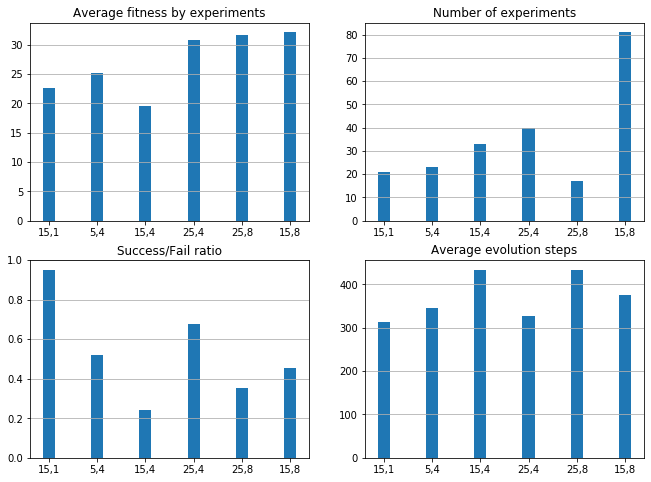

In [53]:
def calc_average_fitness_by_mutation(statistics_files):
    
    mutation = ""
    average_fitness = dict()
    calculations = dict()
    ok_saved = 0
    ok = dict()
    steps_saved = 0
    steps = dict()
    current_fitness = 0
    
    def add_to_current_mutation(line):
        nonlocal average_fitness, calculations, mutation, ok_saved
        current_percent = line.split(':')[1].split('.')[0].strip()
        current_bits = ""
        try:
            current_bits = line.split('to')[1].split('bits')[0].strip()
        except:
            current_bits = "1"
        mutation = current_percent + ',' + current_bits
        calculations[mutation] = calculations.get(mutation, 0) + 1
        average_fitness[mutation] = average_fitness.get(mutation, 0) + float(current_fitness.replace(',', '.'))
        ok[mutation] = ok.get(mutation, 0) + ok_saved
        steps[mutation] = steps.get(mutation, 0) + steps_saved
        
    def get_fitness_add(line):
        nonlocal current_fitness
        current_fitness = line.split(':')[2].strip()[:-1]
        
    def get_ok_not_ok(line):
        nonlocal ok, mutation, ok_saved, steps_saved
        is_ok = line.split
        ok_saved = (1 if line.split('|')[0] == "OK" else 0) 
        steps_saved = int(line.split('after')[1].split(' ')[1]) 
        
    
    analyze(statistics_files, (get_ok_not_ok, 1), (get_fitness_add, 2), (add_to_current_mutation, 7))
    
    for key in average_fitness:
        if (calculations[key] != 0):
            average_fitness[key] /= calculations[key]
            ok[key] /= calculations[key]
            steps[key] /= calculations[key]
        
    return (average_fitness, calculations, ok, steps)

def visualise_mutation_fitness(res):
    plt.rcParams["figure.figsize"] = (11,8)
    fig, ax = plt.subplots(2, 2)
    ax[0][0].bar(res[0].keys(), res[0].values(), 0.25)
    ax[0][0].grid(True, axis='y')
    ax[0][0].set_title('Average fitness by experiments')
    ax[0][1].bar(res[1].keys(), res[1].values(), 0.25)
    ax[0][1].grid(True, axis='y')
    ax[0][1].set_title('Number of experiments')
    ax[1][0].bar(res[2].keys(), res[2].values(), 0.25)
    ax[1][0].grid(True, axis='y')
    ax[1][0].set_title('Success/Fail ratio')
    ax[1][1].bar(res[3].keys(), res[3].values(), 0.25)
    ax[1][1].grid(True, axis='y')
    ax[1][1].set_title('Average evolution steps')

res = calc_average_fitness_by_mutation(get_pattern_files("PtnSquare552"))
visualise_mutation_fitness(res)


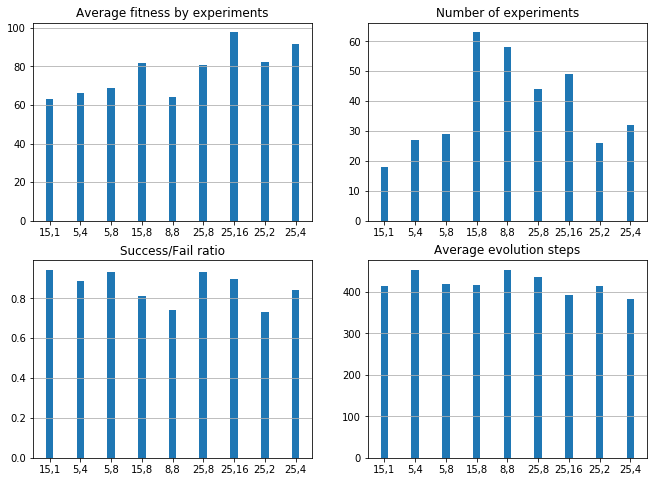

In [60]:
res = calc_average_fitness_by_mutation(get_pattern_files("PtnElka552"))
visualise_mutation_fitness(res)

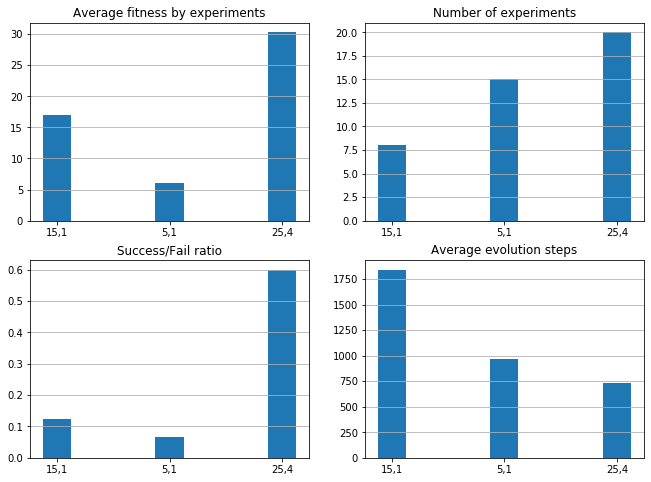

In [55]:
res = calc_average_fitness_by_mutation(get_pattern_files("PtnElka551"))
visualise_mutation_fitness(res)

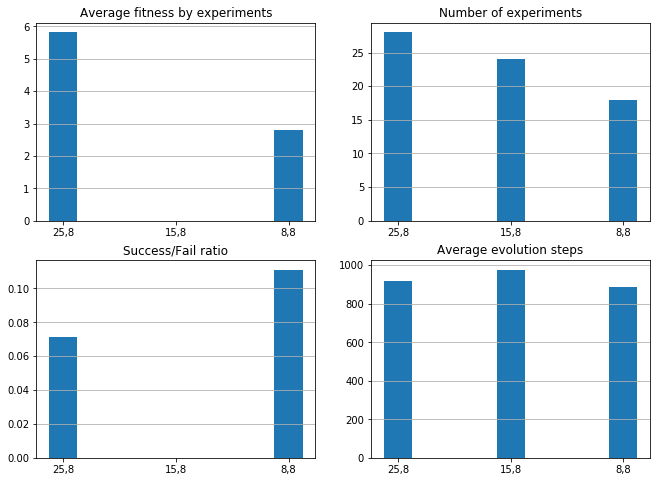

In [56]:
res = calc_average_fitness_by_mutation(get_pattern_files("PtnFive755"))
visualise_mutation_fitness(res)

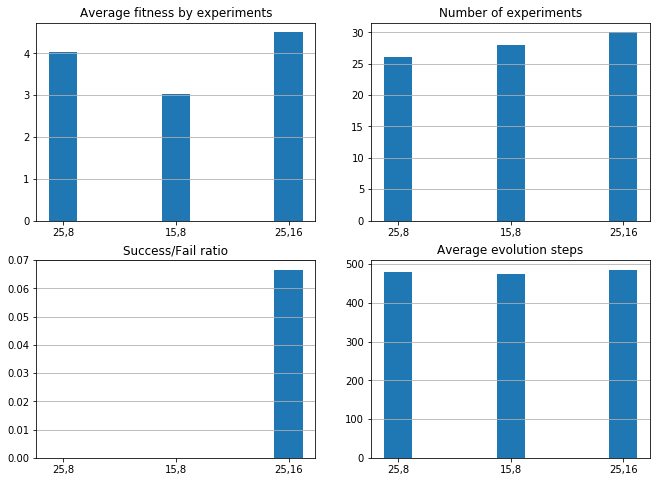

In [57]:
res = calc_average_fitness_by_mutation(get_pattern_files("PtnTriangle576-half-sym"))
visualise_mutation_fitness(res)

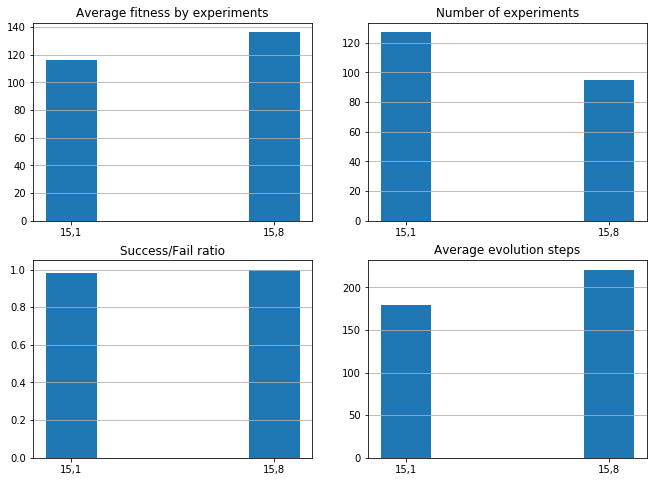

In [58]:
res = calc_average_fitness_by_mutation(get_pattern_files("PtnCross551"))
visualise_mutation_fitness(res)